In [1]:
import kwant
import numpy as np
import matplotlib.pyplot as plt


s0 = np.identity(2)
sz = np.diag([1, -1])


graphene = kwant.lattice.general(
    [[1, 0], [1 / 2, np.sqrt(3) / 2]], [[0, 0], [0, 1 / np.sqrt(3)]]
)
a, b = graphene.sublattices

# create bulk system
bulk_graphene = kwant.Builder(kwant.TranslationalSymmetry(*graphene.prim_vecs))
# add sublattice potential
m0 = 0

bulk_graphene[a.shape((lambda pos: True), (0, 0))] = m0 * s0
bulk_graphene[b.shape((lambda pos: True), (0, 0))] = -m0 * s0
# add hoppings between sublattices
bulk_graphene[graphene.neighbors(1)] = s0

# use kwant wraparound to sample bulk k-space
wrapped_syst_unfinalized = kwant.wraparound.wraparound(bulk_graphene)
wrapped_syst = kwant.wraparound.wraparound(bulk_graphene).finalized()


# return a hamiltonian for a given kx, ky
@np.vectorize
def hamiltonian_return(kx, ky, params={}):
    ham = wrapped_syst.hamiltonian_submatrix(params={**params, **dict(k_x=kx, k_y=ky)})
    return ham

Now we sample the non-interacting hamiltonian on a k-grid:

In [32]:
def mean_field_F(vals, vecs, E_F):
    N_ks = vecs.shape[0]
    unocc_vals = vals > E_F

    def mf_generator(i, j):
        occ_vecs = vecs[i, j]
        occ_vecs[:, unocc_vals[i, j]] = 0
        F_ij = occ_vecs @ occ_vecs.conj().T
        return F_ij

    F = np.array([[mf_generator(i, j) for i in range(N_ks)] for j in range(N_ks)])
    return F


def get_fermi_energy(vals, filling):
    norbs = vals.shape[-1]
    vals_flat = np.sort(vals.flatten())
    ne = len(vals_flat)
    ifermi = int(round(ne * filling / norbs))
    if ifermi >= ne:
        ifermi = ne - 1
    sorte = np.sort(vals_flat)  # sorted eigenvalues
    if ifermi == 0:
        return sorte[0]
    fermi = (sorte[ifermi - 1] + sorte[ifermi]) / 2.0  # fermi energy
    return fermi


from scipy.signal import convolve2d


def convolution(M1, M2):
    cell_size = M2.shape[-1]
    V_output = np.array(
        [
            [
                convolve2d(M1[:, :, i, j], M2[:, :, i, j], boundary="wrap", mode="same")
                for i in range(cell_size)
            ]
            for j in range(cell_size)
        ]
    )
    V_output = np.transpose(V_output, axes=(2, 3, 0, 1))
    return V_output

In [33]:
def func_onsite(site, U):
    return U * np.ones((2, 2))


def func_hop(site1, site2, V):
    rij = np.linalg.norm(site1.pos - site2.pos)
    return V * np.ones((2, 2))


lattice = graphene
syst = wrapped_syst_unfinalized


def compute_Vk(dummy_syst, kx, ky, params={}):
    V = dummy_syst.hamiltonian_submatrix(params={**params, **dict(k_x=kx, k_y=ky)})
    return V


def potential_to_hamiltonian(
    syst, lattice, func_onsite, func_hop, params, nk_axis, max_neighbor=1
):
    V = kwant.Builder(kwant.TranslationalSymmetry(*lattice.prim_vecs))
    V[syst.sites()] = func_onsite
    for neighbors in range(max_neighbor):
        V[lattice.neighbors(neighbors + 1)] = func_hop
    wrapped_V = kwant.wraparound.wraparound(V).finalized()

    return np.array(
        [
            [
                compute_Vk(dummy_syst=wrapped_V, kx=kx, ky=ky, params=params)
                for kx in nk_axis
            ]
            for ky in nk_axis
        ]
    )

In [34]:
Us = np.linspace(1e-6, 5, 10)
Vs = np.linspace(1e-6, 5, 10)

In [115]:
from numpy.linalg import qr
from functools import partial


def generate_mf_k(syst, params, nk_axis):
    return np.array(
        [
            [compute_Vk(dummy_syst=syst, kx=kx, ky=ky, params=params) for kx in nk_axis]
            for ky in nk_axis
        ]
    )


def scf_loop(mf, H_int, scf_syst, nk_axis, hamiltonians_0, filling=2, max_neighbor=1):
    mf = mf.reshape(
        max_neighbor + 1,
        2,
        hamiltonians_0.shape[-1] // 2,
        hamiltonians_0.shape[-1] // 2,
    )
    params = dict(mat=mf)
    mf_k = generate_mf_k(syst=scf_syst, nk_axis=nk_axis, params=params)

    H0_int = H_int[0, 0]

    # Generate the Hamiltonian
    hamiltonians = hamiltonians_0 + mf_k
    vals, vecs = np.linalg.eigh(hamiltonians)
    vecs = qr(vecs)[0]
    # Compute new Fermi energy
    E_F = get_fermi_energy(vals, filling)
    F = mean_field_F(vals, vecs, E_F=E_F)
    rho = np.diag(np.average(F, axis=(0, 1)))
    exchange_mf = convolution(F, H_int) * len(nk_axis) ** (-2)
    direct_mf = np.diag(np.einsum("i,ij->j", rho, H0_int))

    mf_new = direct_mf - exchange_mf

    diff = mf_new - mf_k

    return np.linalg.norm(diff) / np.prod(diff.shape)

In [ ]:
def generate_guess(max_neighbor, n):
    guesses = []
    for i in range(max_neighbor + 1):
        guess = (
            0.5 * np.random.rand(n, n) * np.exp(1j * 2 * np.pi * np.random.rand(n, n))
        )
        guess = 0.5 * (guess + guess.T.conj())
        guess = np.stack([guess.real, guess.imag])
        guesses.append(guess)
    return np.asarray(guesses)


def generate_scf_syst(syst=syst, max_neighbor=1):
    scf = kwant.Builder(kwant.TranslationalSymmetry(*lattice.prim_vecs))

    def scf_onsite(site, mat):
        return mat[0, 0] + 1j * mat[0, 1]

    scf[syst.sites()] = scf_onsite
    for neighbor in range(max_neighbor):

        def scf_hopping(site1, site2, mat):
            return mat[neighbor + 1, 0] + mat[neighbor + 1, 1]

        scf[lattice.neighbors(neighbor + 1)] = scf_hopping
    wrapped_scf = kwant.wraparound.wraparound(scf).finalized()
    return wrapped_scf


from scipy.optimize import minimize, anderson, fmin, root


def compute_gap(U, V, max_neighbor=1, nk=9):
    nk_axis = np.linspace(0, 2 * np.pi, nk, endpoint=False)
    hamiltonians_0 = np.array(
        [[hamiltonian_return(kx, ky) for kx in nk_axis] for ky in nk_axis]
    )
    # Generate interacting matrix
    Uk = potential_to_hamiltonian(
        syst=wrapped_syst_unfinalized,
        lattice=graphene,
        func_onsite=func_onsite,
        func_hop=func_hop,
        params=dict(U=1, V=0),
        nk_axis=nk_axis,
    )

    Vk = potential_to_hamiltonian(
        syst=wrapped_syst_unfinalized,
        lattice=graphene,
        func_onsite=func_onsite,
        func_hop=func_hop,
        params=dict(U=0, V=1),
        nk_axis=nk_axis,
    )
    H_int = U * Uk + V * Vk
    guess = generate_guess(max_neighbor=max_neighbor, n=hamiltonians_0.shape[-1] // 2)
    scf_syst = generate_scf_syst()
    fun = partial(
        scf_loop,
        H_int=H_int,
        scf_syst=scf_syst,
        hamiltonians_0=hamiltonians_0,
        nk_axis=nk_axis,
        max_neighbor=max_neighbor,
    )
    mf = minimize(fun, guess.flatten(), tol=1e-3).x
    mf = mf.reshape(
        max_neighbor + 1,
        2,
        hamiltonians_0.shape[-1] // 2,
        hamiltonians_0.shape[-1] // 2,
    )
    nk_axis = np.linspace(0, 2 * np.pi, 30, endpoint=False)
    hamiltonians_0 = np.array(
        [[hamiltonian_return(kx, ky) for kx in nk_axis] for ky in nk_axis]
    )
    scf_mf_k = generate_mf_k(syst=scf_syst, nk_axis=nk_axis, params=dict(mat=mf))
    vals, vecs = np.linalg.eigh(hamiltonians_0 + scf_mf_k)
    E_F = get_fermi_energy(vals, 2)
    emax = np.max(vals[vals <= E_F])
    emin = np.min(vals[vals > E_F])
    return np.abs(emin - emax)


from tqdm import tqdm

gap = []
for U in tqdm(Us):
    gap_U = []
    for V in Vs:
        gap_U.append(compute_gap(U, V))
    gap.append(gap_U)

 80%|████████  | 8/10 [11:09<02:54, 87.27s/it]

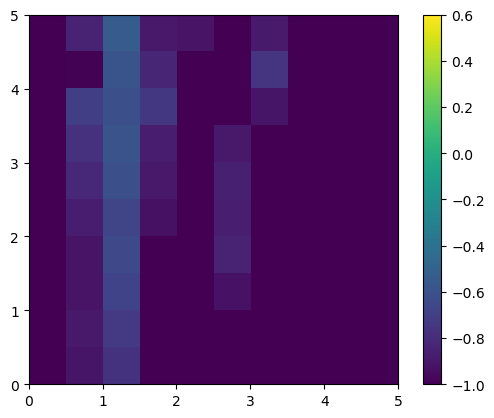

In [126]:
gap = np.asarray(gap, dtype=float)
plt.imshow(np.log10(gap).T, origin='lower', extent=(0, 5, 0, 5), vmin=-1, vmax=0.6)
plt.colorbar()